<a href="https://colab.research.google.com/github/Rishabhjain2003/i.mobilothon-4.0/blob/main/Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Input, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
data = pd.read_csv('/content/cleaned_engine_data.csv')

In [3]:
X = data.drop(columns=['Engine Condition'])  # Assuming 'Engine Condition' is the target variable
y = data['Engine Condition']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [6]:
class MultiHeadAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, **kwargs):
        super(MultiHeadAttentionLayer, self).__init__(**kwargs)
        self.num_heads = num_heads

    def build(self, input_shape):
        self.W_query = self.add_weight(name='query_weight', shape=(input_shape[-1], input_shape[-1]), initializer='he_normal')
        self.W_key = self.add_weight(name='key_weight', shape=(input_shape[-1], input_shape[-1]), initializer='he_normal')
        self.W_value = self.add_weight(name='value_weight', shape=(input_shape[-1], input_shape[-1]), initializer='he_normal')
        super(MultiHeadAttentionLayer, self).build(input_shape)

    def call(self, inputs):
        queries = tf.matmul(inputs, self.W_query)
        keys = tf.matmul(inputs, self.W_key)
        values = tf.matmul(inputs, self.W_value)

        # Compute attention scores and weights
        scores = tf.matmul(queries, keys, transpose_b=True) / tf.sqrt(float(inputs.shape[-1]))
        attention_weights = tf.nn.softmax(scores, axis=-1)

        # Compute the context vector as a weighted sum of values
        context_vector = tf.matmul(attention_weights, values)
        return tf.reduce_sum(context_vector, axis=1)


In [7]:
input_layer = Input(shape=(X_train_scaled.shape[1], 1))

In [8]:
cnn_layer = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(input_layer)
cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)
cnn_layer = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(cnn_layer)
cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)
cnn_layer = Flatten()(cnn_layer)

In [9]:
dense_layer = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(cnn_layer)
dense_layer = Dropout(0.5)(dense_layer)
dense_layer = BatchNormalization()(dense_layer)
dense_layer = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(dense_layer)
dense_layer = Dropout(0.4)(dense_layer)
dense_layer = BatchNormalization()(dense_layer)

In [10]:
attention_layer = MultiHeadAttentionLayer(num_heads=4)(dense_layer)

In [11]:
# Flatten the attention layer output to match the dense layer's shape
attention_layer_flattened = Flatten()(attention_layer)

# Now the concatenation should work
concat_layer = tf.keras.layers.concatenate([dense_layer, attention_layer_flattened])


In [12]:
fc_layer = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(concat_layer)
fc_layer = Dropout(0.4)(fc_layer)
fc_layer = BatchNormalization()(fc_layer)
fc_layer = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(fc_layer)
fc_layer = Dropout(0.3)(fc_layer)
output_layer = Dense(1)(fc_layer)

In [13]:
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [14]:
def scheduler(epoch, lr):
    if epoch > 50:
        return lr * 0.5
    return lr

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('/mnt/data/best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

In [16]:
history = model.fit(
    X_train_scaled[..., np.newaxis], y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=64,
    callbacks=[early_stopping, lr_reduction, model_checkpoint, lr_scheduler],
    verbose=1
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/300
182/184 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0190 - mae: 0.7453
Epoch 1: val_loss improved from inf to 0.39935, saving model to /mnt/data/best_model.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 1.0137 - mae: 0.7434 - val_loss: 0.3993 - val_mae: 0.5519 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/300
180/184 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3929 - mae: 0.5020
Epoch 2: val_loss improved from 0.39935 to 0.37623, saving model to /mnt/data/best_model.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.3922 - mae: 0.5017 - val_loss: 0.3762 - val_mae: 0.5434 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/300
181/184 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3297 - mae: 0.4772
Epoch 3: val_loss improved from 0.37623 to 0.35994, saving mo

In [17]:
y_pred = model.predict(X_test_scaled[..., np.newaxis])

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [18]:
y_pred

array([[0.7152233 ],
       [0.85680306],
       [0.45441228],
       ...,
       [0.5302477 ],
       [0.73303246],
       [0.6674125 ]], dtype=float32)

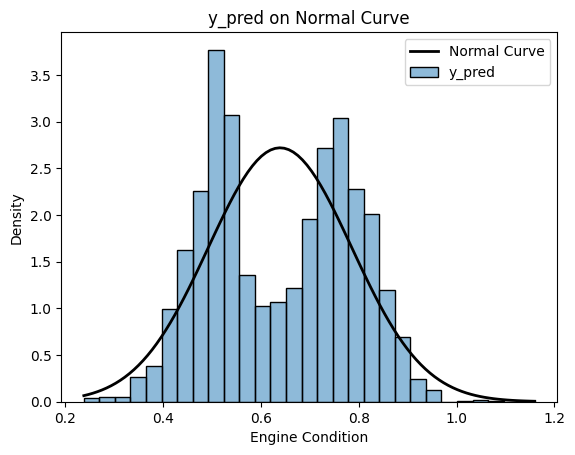

In [31]:
# Calculate mean and standard deviation of y_pred
mu, std = stats.norm.fit(y_pred)

# Create a normal distribution based on the fitted parameters
xmin, xmax = np.min(y_pred), np.max(y_pred)
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)

# Plot the normal curve
plt.plot(x, p, 'k', linewidth=2, label='Normal Curve')

# Plot the y_pred values as a histogram
sns.histplot(y_pred, kde=False, stat="density", label='y_pred')

plt.title('y_pred on Normal Curve')
plt.xlabel('Engine Condition')
plt.ylabel('Density')
plt.legend()
plt.show()

In [19]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [20]:
def regression_accuracy(y_true, y_pred, tolerance=0.1):
    within_tolerance = np.abs(y_true - y_pred.flatten()) <= tolerance * np.abs(y_true)
    accuracy = np.mean(within_tolerance) * 100
    return accuracy

accuracy = regression_accuracy(y_test, y_pred, tolerance=0.1)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R2 Score: {r2}")
print(f"Accuracy (within 10% tolerance): {accuracy}%")

Mean Squared Error (MSE): 0.2132068461699432
Mean Absolute Error (MAE): 0.42247076443128745
R2 Score: 0.0887833833694458
Accuracy (within 10% tolerance): 1.5548281505728314%


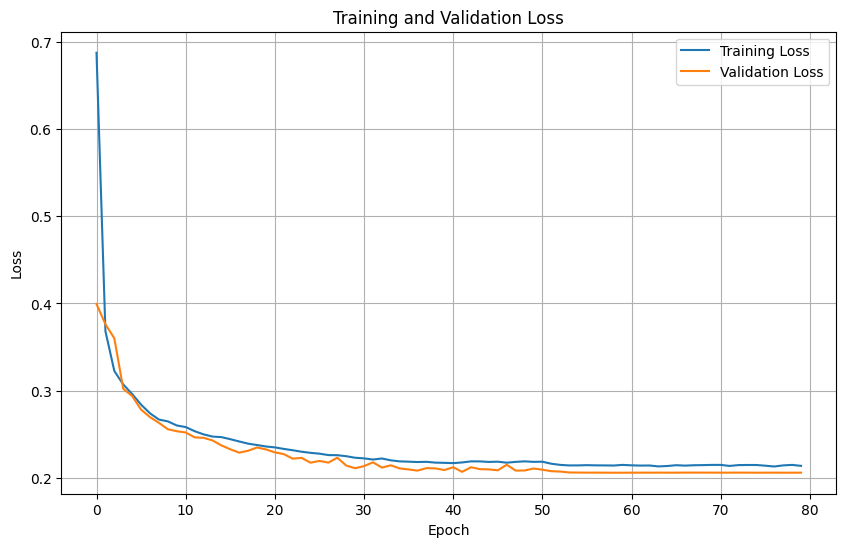

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [22]:
probabilities = model.predict(X_test_scaled[..., np.newaxis])  # Probabilities for class 1

# Define threshold probability
threshold = 0.6  # Adjust as needed

# Identify indices where maintenance might be needed
maintenance_indices = []

for i in range(len(probabilities)):
    if probabilities[i] > threshold:
        maintenance_indices.append(i)

# Convert maintenance indices to a range of indices
maintenance_ranges = []
start_index = maintenance_indices[0]
for i in range(1, len(maintenance_indices)):
    if maintenance_indices[i] != maintenance_indices[i-1] + 1:
        end_index = maintenance_indices[i-1]
        maintenance_ranges.append((start_index, end_index))
        start_index = maintenance_indices[i]
end_index = maintenance_indices[-1]
maintenance_ranges.append((start_index, end_index))

# Convert index ranges to date ranges
X_test_df = pd.DataFrame(X_test)
maintenance_date_ranges = []
for start, end in maintenance_ranges:
    start_date = X_test_df.index[start]
    end_date = X_test_df.index[end]
    maintenance_date_ranges.append((start_date, end_date))

# Display maintenance date ranges
for start, end in maintenance_date_ranges:
    print("Maintenance might be needed between", start, "and", end)

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Maintenance might be needed between 8341 and 18251
Maintenance might be needed between 5746 and 5746
Maintenance might be needed between 4848 and 12850
Maintenance might be needed between 4347 and 4347
Maintenance might be needed between 7822 and 7822
Maintenance might be needed between 13298 and 13298
Maintenance might be needed between 12518 and 10480
Maintenance might be needed between 2174 and 15727
Maintenance might be needed between 9639 and 9639
Maintenance might be needed between 4743 and 4743
Maintenance might be needed between 10784 and 10784
Maintenance might be needed between 7839 and 7839
Maintenance might be needed between 12859 and 12859
Maintenance might be needed between 10755 and 10755
Maintenance might be needed between 15443 and 15443
Maintenance might be needed between 17485 and 17485
Maintenance might be needed between 2629 and 2629
Maintenance might be needed between 8698 and 8698
Maintenance might be needed between 15256 

In [23]:
probabilities = model.predict(X_test_scaled[..., np.newaxis])  # Probabilities for class 1

# Define threshold probability
threshold = 0.6  # Adjust as needed

# Identify indices where maintenance might be needed
maintenance_indices = []

for i in range(len(probabilities)):
    if probabilities[i] > threshold:
        maintenance_indices.append(i)

# Convert maintenance indices to a range of indices
maintenance_ranges = []
start_index = maintenance_indices[0]
for i in range(1, len(maintenance_indices)):
    if maintenance_indices[i] != maintenance_indices[i-1] + 1:
        end_index = maintenance_indices[i-1]
        maintenance_ranges.append((start_index, end_index))
        start_index = maintenance_indices[i]
end_index = maintenance_indices[-1]
maintenance_ranges.append((start_index, end_index))

# Convert index ranges to number of days
maintenance_days = []
for start, end in maintenance_ranges:
    num_days = end - start + 1
    maintenance_days.append(num_days)

# Display maintenance duration in days
for num_days in maintenance_days:
    print("Maintenance might be needed for", num_days, "days")

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Maintenance might be needed for 2 days
Maintenance might be needed for 1 days
Maintenance might be needed for 5 days
Maintenance might be needed for 1 days
Maintenance might be needed for 1 days
Maintenance might be needed for 1 days
Maintenance might be needed for 2 days
Maintenance might be needed for 3 days
Maintenance might be needed for 1 days
Maintenance might be needed for 1 days
Maintenance might be needed for 1 days
Maintenance might be needed for 1 days
Maintenance might be needed for 1 days
Maintenance might be needed for 1 days
Maintenance might be needed for 1 days
Maintenance might be needed for 1 days
Maintenance might be needed for 1 days
Maintenance might be needed for 1 days
Maintenance might be needed for 1 days
Maintenance might be needed for 2 days
Maintenance might be needed for 2 days
Maintenance might be needed for 2 days
Maintenance might be needed for 1 days
Maintenance might be needed for 2 days
Maintenance might be ne

In [24]:
thresholds = {
    'Engine rpm': 0.5,  # Lowered threshold assuming minor deviations might indicate potential issues.
    'Lub oil pressure': 0.7,  # Raised threshold to ensure early detection of lubrication system issues.
    'Fuel pressure': 0.6,  # Kept threshold unchanged assuming moderate deviations are indicative of potential problems.
    'Coolant pressure': 0.7,  # Raised threshold to detect cooling system issues more sensitively.
    'lub oil temp': 0.7,  # Slightly raised threshold to detect temperature anomalies earlier.
    'Coolant temp': 0.6,  # Kept threshold unchanged assuming moderate deviations might indicate potential issues.
    'Temperature_difference': 0.7  # Slightly raised threshold for early detection of temperature gradient anomalies.
}



# Make probabilistic predictions
probabilities = model.predict(X_test_scaled[..., np.newaxis])
print(probabilities) # Probabilities for class 1

# Identify indices where maintenance might be needed for each parameter
maintenance_indices = {}

for parameter, threshold in thresholds.items():
    parameter_indices = []
    for i in range(len(probabilities)):
        if probabilities[i] > threshold:
            parameter_indices.append(i)
    maintenance_indices[parameter] = parameter_indices

# Convert maintenance indices to a range of indices for each parameter
maintenance_ranges = {}

for parameter, indices in maintenance_indices.items():
    parameter_ranges = []
    start_index = indices[0]
    for i in range(1, len(indices)):
        if indices[i] != indices[i-1] + 1:
            end_index = indices[i-1]
            parameter_ranges.append((start_index, end_index))
            start_index = indices[i]
    end_index = indices[-1]
    parameter_ranges.append((start_index, end_index))
    maintenance_ranges[parameter] = parameter_ranges

# Convert index ranges to number of days for each parameter
maintenance_days = {}

for parameter, ranges in maintenance_ranges.items():
    parameter_days = []
    for start, end in ranges:
        num_days = end - start + 1
        parameter_days.append(num_days)
    maintenance_days[parameter] = parameter_days

# Display maintenance duration in days for each parameter
for parameter, days in maintenance_days.items():
    print("Maintenance might be needed for", parameter, "for", days, "days")

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[0.7152233 ]
 [0.85680306]
 [0.45441228]
 ...
 [0.5302477 ]
 [0.73303246]
 [0.6674125 ]]
Maintenance might be needed for Engine rpm for [2, 9, 1, 7, 3, 3, 3, 2, 5, 1, 3, 3, 2, 4, 7, 5, 2, 1, 4, 4, 10, 5, 25, 3, 2, 20, 1, 2, 6, 4, 6, 2, 6, 9, 1, 2, 5, 10, 6, 5, 1, 3, 4, 2, 6, 6, 2, 1, 6, 6, 1, 2, 2, 2, 3, 14, 3, 4, 14, 3, 3, 4, 4, 1, 3, 2, 1, 8, 2, 8, 5, 16, 4, 6, 2, 6, 8, 3, 3, 6, 10, 6, 4, 1, 2, 5, 3, 2, 1, 4, 1, 5, 5, 8, 2, 20, 24, 3, 1, 4, 3, 6, 1, 3, 11, 2, 4, 1, 9, 2, 1, 7, 3, 7, 2, 7, 6, 5, 1, 2, 2, 4, 3, 1, 1, 5, 2, 4, 2, 4, 4, 7, 6, 34, 3, 5, 3, 7, 1, 22, 6, 10, 3, 4, 1, 6, 7, 1, 10, 4, 2, 6, 6, 4, 1, 3, 1, 5, 1, 16, 5, 2, 2, 5, 4, 2, 1, 9, 18, 1, 1, 8, 4, 2, 15, 6, 7, 8, 5, 7, 7, 2, 4, 4, 9, 8, 10, 5, 1, 16, 22, 11, 3, 1, 5, 7, 2, 2, 12, 3, 11, 3, 10, 5, 3, 1, 1, 3, 2, 2, 9, 2, 2, 3, 3, 6, 1, 1, 3, 12, 7, 1, 8, 4, 5, 1, 1, 4, 6, 3, 4, 2, 8, 1, 2, 2, 1, 7, 2, 3, 5, 1, 3, 3, 4, 6, 4, 7, 2, 2, 9, 3, 1, 1, 8, 2, 7, 5, 1, 12, 2, 3, 20, 1, 2

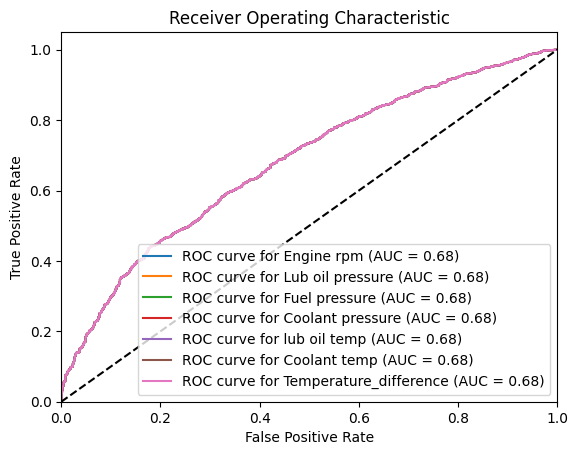

In [25]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each parameter
roc_curves = {}
for parameter in thresholds.keys():
    fpr, tpr, _ = roc_curve(y_test, probabilities)  # Assuming y_test is your true labels
    roc_auc = auc(fpr, tpr)
    roc_curves[parameter] = (fpr, tpr, roc_auc)

# Plot ROC curve for each parameter
import matplotlib.pyplot as plt

plt.figure()
for parameter, (fpr, tpr, roc_auc) in roc_curves.items():
    plt.plot(fpr, tpr, label='ROC curve for %s (AUC = %0.2f)' % (parameter, roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [26]:
# Display maintenance duration in weeks for each parameter
for parameter, days_list in maintenance_days.items():
    weeks_list = [int(days / 7) if days > 7 else 0 for days in days_list]
    print("Maintenance might be needed for", parameter, "for", weeks_list, "weeks")

Maintenance might be needed for Engine rpm for [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 2, 3, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0

In [27]:
# Initialize a dictionary to store the maintenance classification for each parameter
maintenance_classification = {}

# Identify maintenance classification for each parameter based on the thresholds
for parameter, threshold in thresholds.items():
    parameter_classification = []
    for probability in probabilities:
        if probability > threshold:
            parameter_classification.append(1)  # Maintenance might be needed
        else:
            parameter_classification.append(0)  # No maintenance needed
    maintenance_classification[parameter] = parameter_classification

# Display maintenance classification for each parameter
for parameter, classification in maintenance_classification.items():
    print("Maintenance classification for", parameter, ":", classification)

# Initialize a list of dictionaries to store maintenance classification for each vehicle
vehicle_maintenance_classification = []

# Populate maintenance classification for each vehicle
for i in range(len(probabilities)):
    vehicle_classification = {}
    for parameter, classification in maintenance_classification.items():
        vehicle_classification[parameter] = classification[i]
    vehicle_maintenance_classification.append(vehicle_classification)

# Display maintenance classification for each vehicle
for i, vehicle_classification in enumerate(vehicle_maintenance_classification):
    print("Maintenance classification for Vehicle", i+1, ":", vehicle_classification)

# Initialize a list to store the overall maintenance classification for each vehicle
overall_maintenance = []

# Identify overall maintenance classification for each vehicle based on the maintenance classification for each parameter
for vehicle_classification in vehicle_maintenance_classification:
    if any(value == 1 for value in vehicle_classification.values()):
        overall_maintenance.append(1)  # Maintenance might be needed
    else:
        overall_maintenance.append(0)  # No maintenance needed

# Display overall maintenance classification for each vehicle
for i, maintenance_needed in enumerate(overall_maintenance):
    print("Overall maintenance classification for Vehicle", i+1, ":", maintenance_needed)


Streaming output truncated to the last 5000 lines.
Maintenance classification for Vehicle 2333 : {'Engine rpm': 1, 'Lub oil pressure': 0, 'Fuel pressure': 0, 'Coolant pressure': 0, 'lub oil temp': 0, 'Coolant temp': 0, 'Temperature_difference': 0}
Maintenance classification for Vehicle 2334 : {'Engine rpm': 0, 'Lub oil pressure': 0, 'Fuel pressure': 0, 'Coolant pressure': 0, 'lub oil temp': 0, 'Coolant temp': 0, 'Temperature_difference': 0}
Maintenance classification for Vehicle 2335 : {'Engine rpm': 1, 'Lub oil pressure': 0, 'Fuel pressure': 1, 'Coolant pressure': 0, 'lub oil temp': 0, 'Coolant temp': 1, 'Temperature_difference': 0}
Maintenance classification for Vehicle 2336 : {'Engine rpm': 1, 'Lub oil pressure': 1, 'Fuel pressure': 1, 'Coolant pressure': 1, 'lub oil temp': 1, 'Coolant temp': 1, 'Temperature_difference': 1}
Maintenance classification for Vehicle 2337 : {'Engine rpm': 1, 'Lub oil pressure': 0, 'Fuel pressure': 0, 'Coolant pressure': 0, 'lub oil temp': 0, 'Coolant tem

In [28]:
# Dictionary containing binary values for each parameter
binary_values = {'Engine rpm': 1, 'Lub oil pressure': 0, 'Fuel pressure': 1, 'Coolant pressure': 0, 'lub oil temp': 0, 'Coolant temp': 1, 'Temperature_difference': 0}

# Dictionary containing weights for each parameter
weights = {'Engine rpm': 0.07, 'Lub oil pressure': 0.21, 'Fuel pressure': 0.14, 'Coolant pressure': 0.7, 'lub oil temp': 0.14, 'Coolant temp': 0.21, 'Temperature_difference': 0.7}

# Calculate the weighted sum
weighted_sum = sum(binary_values[param] * weights[param] for param in binary_values)

# Display the weighted sum
print("Weighted sum:", weighted_sum)

Weighted sum: 0.42000000000000004


In [29]:
# Save the entire model
model.save('predictive_maintenance_ann.keras')